Per vedere se aggiungere lo stato unbound e la normaliz rompono tutto o no

In [3]:
import sys
sys.path.append('..')
import selex_dca, utils

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from utils import one_hot
import selex_dca
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

from adabmDCA.utils import init_parameters, init_chains, get_device, get_dtype, get_mask_save
from adabmDCA.sampling import get_sampler
from adabmDCA.training import train_graph

/home/scrotti/Aptamer2025py/experiments/../selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


File names for data

In [5]:
experiment_id = "Dop8V030"
round_ids = ["ARN", "R01", "R02N"]

In [6]:
device = torch.device('cpu')
dtype = torch.float32

Extract sequences and compute 1st and 2nd moment statistics

In [7]:
sequences = [utils.sequences_from_file(experiment_id, round_id, device) for round_id in round_ids]

In [8]:
sequences_oh = [one_hot(seq).to(dtype=dtype) for seq in sequences]

In [9]:
total_reads = torch.Tensor([s.shape[0] for s in sequences_oh])
fi0, _, _ = utils.frequences_from_sequences_oh(sequences_oh[0])

In [32]:
import importlib
importlib.reload(utils)
importlib.reload(selex_distribution)
importlib.reload(energy_models)
importlib.reload(sampling)
importlib.reload(training)
importlib.reload(callback)

<module 'callback' from '/home/scrotti/Aptamer2025py/experiments/../callback.py'>

In [33]:
tr = tree.Tree()
tr.add_node(-1, name = "R01")
tr.add_node(0, name = "R02N")

selected_modes = torch.BoolTensor(
    [[1, 0], [1, 0]]
)

In [68]:
L, q = sequences_oh[0][0].shape

k = torch.zeros(L, q, dtype=dtype)
# k = torch.log(fi0)
h = torch.zeros(L, q, dtype=dtype)
J = torch.zeros(L, q, L, q, dtype=dtype)

Ns0 = energy_models.IndepSites(k)
potts = energy_models.Potts(J, h)
unbound = energy_models.ConstantEnergy(-10.0)

ps = selex_distribution.MultiModeDistribution(potts, unbound, normalized=True)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)

In [69]:
batch_size = 10**6
data_loaders = [data_loading.SelexRoundDataLoader(seq_oh, batch_size=batch_size, device=device) for seq_oh in sequences_oh]
n_rounds = len(data_loaders) 

In [70]:
n_chains = 10**4
chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype)
log_weights = torch.zeros(n_rounds, n_chains, dtype=dtype)

In [71]:
callbacks = [callback.ConvergenceMetricsCallback(), callback.PearsonCovarianceCallback()]

In [91]:
n_sweeps = 10
lr = 0.01
target_pearson = 1
max_epochs = 1000

training.train(model, data_loaders, total_reads, chains, n_sweeps, max_epochs, target_pearson, lr=lr, callbacks=callbacks, log_weights=log_weights)

 0.00%[                                                                   ] Epoch: 0/1000 [00:00, ?it/s]

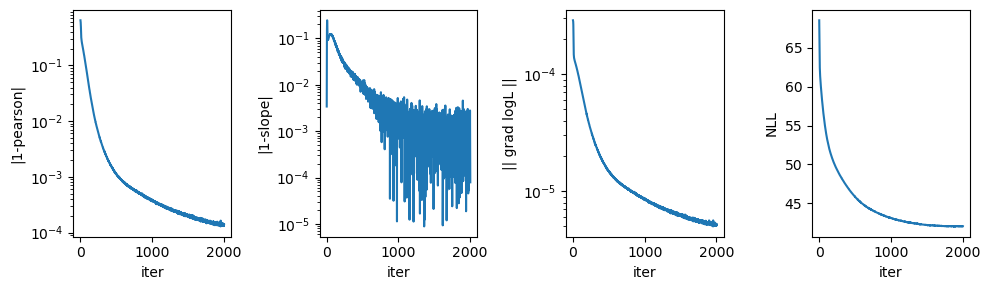

In [92]:
callbacks[0].plot();

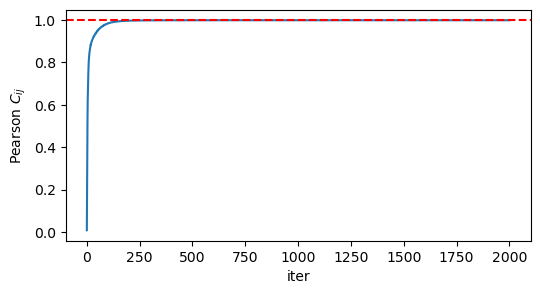

In [121]:
fig, ax = callbacks[1].plot()
ax.axhline(1, color='r', linestyle='--')

<IPython.core.display.Latex object>

Multi-round


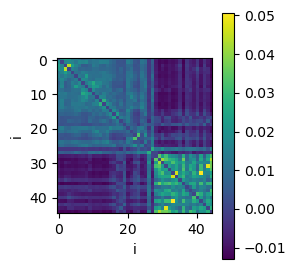

In [122]:
from IPython.display import display, Latex

potts_zerosum = potts.set_zerosum_gauge()
J = potts_zerosum.J.detach()
h = potts_zerosum.h.detach()

pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(J)
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
plt.colorbar(im)
plt.tight_layout()
display(Latex("$F_{ij}=\\sqrt {\\sum_{ab}(J_{ij}^{ab})^2}$"))
print('Multi-round')

## Try to simply apply DCA to the last round

In [ ]:
fi_target, fij_target, _ = utils.frequences_from_sequences_oh(sequences_oh[2], pseudo_count=0.0)

In [ ]:
nchains = 10**4
sampler_alg = "gibbs"
sampler = torch.jit.script(get_sampler(sampler_alg));

In [ ]:
params = init_parameters(fi=fi_target)
# params["bias"] = torch.zeros(L, q)
chains_dca = init_chains(num_chains=nchains, L=L, q=q, device=device, fi=fi_target, dtype=dtype)
# Mask for removing the autocorrelations
mask = torch.ones(size=(L, q, L, q), dtype=torch.bool, device=device)
mask[torch.arange(L), :, torch.arange(L), :] = 0
log_weights_dca = torch.zeros(nchains, device=device, dtype=dtype)

In [ ]:
target = 0.999
chains_dca, params, log_weights_dca, history = train_graph(
    sampler=sampler,
    chains=chains_dca,
    fi_target=fi_target,
    fij_target=fij_target,
    params=params,
    mask=mask,
    log_weights=log_weights_dca,
    nsweeps=10,
    lr=0.01,
    max_epochs=8000,
    target_pearson=target,
    )

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(history["epochs"], history["pearson"], label="Pearson training")
ax.axhline(target, ls="--", color="red", label="Training target")
ax.set_xlabel("Epochs")
ax.set_ylabel(r"Pearson $C_{ij}$ correlation")
ax.legend()
fig.tight_layout()

<IPython.core.display.Latex object>

DCA on last round


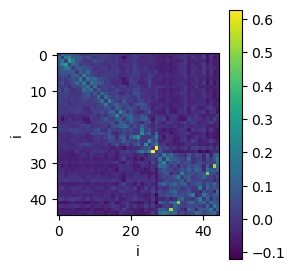

In [100]:
from IPython.display import display, Latex

J_lastround, h_lastround= utils.set_zerosum_gauge(params['coupling_matrix'], params['bias'])

pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(J_lastround)
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
plt.colorbar(im)
plt.tight_layout()
display(Latex("$F_{ij}=\\sqrt {\\sum_{ab}(J_{ij}^{ab})^2}$"))
print('DCA on last round')

0.7816498875617981

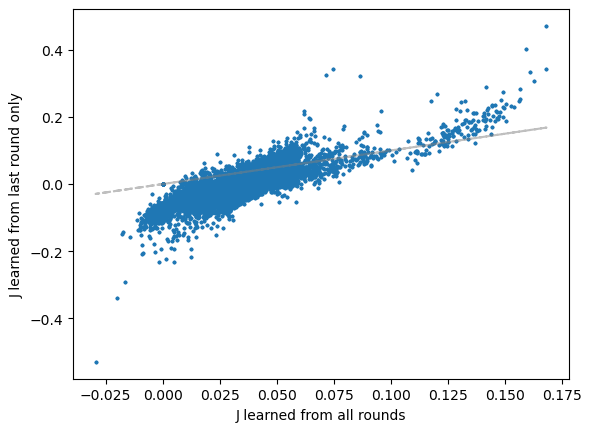

In [123]:
plt.scatter(J, J_lastround, s=3)
plt.xlabel('J learned from all rounds')
plt.ylabel('J learned from last round only')
plt.plot(J.reshape(-1), J.reshape(-1), ls='--', color='gray', alpha=0.5)
torch.corrcoef(torch.stack((J.reshape(-1), J_lastround.reshape(-1))))[0,1].item()

-0.06432941555976868

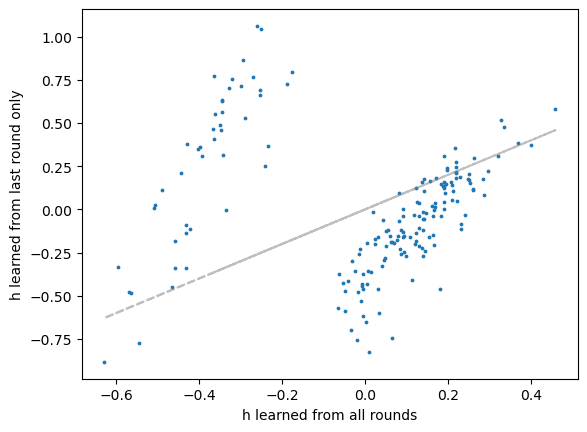

In [124]:
plt.scatter(h, h_lastround, s=3)
plt.xlabel('h learned from all rounds')
plt.ylabel('h learned from last round only')
plt.plot(h.reshape(-1), h.reshape(-1), ls='--', color='gray', alpha=0.5)
torch.corrcoef(torch.stack((h.reshape(-1), h_lastround.reshape(-1))))[0,1].item()